In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/mammoth


In [66]:

import importlib
import math
import os
import socket
import sys
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import time
mammoth_path = os.path.abspath(os.path.join('.'))
if mammoth_path not in sys.path:
    print(mammoth_path)
    sys.path.append(mammoth_path)
    sys.path.append(mammoth_path + '/datasets')
    sys.path.append(mammoth_path + '/backbone')
    sys.path.append(mammoth_path + '/models')
    sys.path.append(mammoth_path + '/utils')


import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch

from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import ImageNet, ImageFolder
from torchvision.models import efficientnet_v2_s, resnet50, ResNet50_Weights, resnet18
import torchvision.transforms as transforms


In [3]:
%ls

LICENSE    gem_license   models/           seq_cifar10.gif  wandb/
README.md  logo.png      perm_mnist.gif    seq_mnist.gif
backbone/  logs/         requirements.txt  seq_tinyimg.gif
data/      logs.txt      rot_mnist.gif     tests/
datasets/  mnist360.gif  scripts/          utils/


In [4]:
logs_path = './logs/results/imagenet/resnet50/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [38]:
res_df = pd.DataFrame(results)
res_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_mom  \
0            no  0.1         True       False   0.00010        0.9   
1            no  0.1         True       False   0.00010        0.9   
2            no  0.1         True       False   0.00010        0.9   
3            no  0.1         True       False   0.00010        0.9   
4            no  0.1         True       False   0.00010        0.9   
..          ...  ...          ...         ...       ...        ...   
168          no  0.3         True       False   0.00002        0.9   
169          no  0.1         True       False   0.00010        0.9   
170          no  0.1         True       False   0.00010        0.9   
171          no  0.1         True       False   0.00010        0.9   
172          no  0.1         True       False   0.00010        0.9   

     optim_nesterov  n_epochs  batch_size  validate_subset  ...  \
0                 0        90          64             1000  ...   
1                 0        90          64             1000  ...   
2                 0        90          64             1000  ...   
3                 0        90          64             1000  ...   
4                 0        90          64             1000  ...   
..              ...       ...         ...              ...  ...   
168               0        90          64             2000  ...   
169               0        90          64             2000  ...   
170               0        90          64             2000  ...   
171               0        90          64             2000  ...   
172               0        90          64             2000  ...   

    final_val_acc_D  buffer_train_time final_train_acc_S  \
0         76.034000        1303.681807          3.333333   
1         76.034000        1324.478126          3.166667   
2         76.034000        1328.220785          3.916667   
3         76.034000        1316.642873          3.500000   
4         76.034000        1230.671725          3.166667   
..              ...                ...               ...   
168       76.033997       47468.244970         14.560000   
169       76.033997      249386.718252         70.608542   
170       76.033997      249701.248674         75.068750   
171       76.033997      249970.982520         75.957292   
172       76.033997      250071.491801         70.822708   

     final_train_leftout_acc_S  final_val_acc_S    MSE  optim_adam  \
0                     0.767263            1.168    NaN         NaN   
1                     1.023018            1.234    NaN         NaN   
2                     0.767263            1.400    NaN         NaN   
3                     1.023018            1.232    NaN         NaN   
4                     1.534527            1.266    NaN         NaN   
..                         ...              ...    ...         ...   
168                  11.253197           12.038   True       False   
169                  70.716113           72.732  False         NaN   
170                  65.345269           67.968  False         NaN   
171                  62.404092           68.994  False         NaN   
172                  66.879795           72.924  False         NaN   

     optim_warmup  optim_cosineanneal n_epochs_stud  
0             NaN                 NaN           NaN  
1             NaN                 NaN           NaN  
2             NaN                 NaN           NaN  
3             NaN                 NaN           NaN  
4             NaN                 NaN           NaN  
..            ...                 ...           ...  
168           5.0               False         120.0  
169           NaN                 NaN           NaN  
170           NaN                 NaN           NaN  
171           NaN                 NaN           NaN  
172           NaN                 NaN           NaN  

[173 rows x 36 columns]

In [153]:
res_df.columns

Index(['distributed', 'lr', 'checkpoints', 'pretrained', 'optim_wd',
       'optim_mom', 'optim_nesterov', 'n_epochs', 'batch_size',
       'validate_subset', 'gpus_id', 'seed', 'notes', 'non_verbose',
       'disable_log', 'validation', 'ignore_other_metrics', 'debug_mode',
       'nowand', 'wandb_entity', 'wandb_project', 'wandb_name', 'buffer_size',
       'minibatch_size', 'alpha', 'noisy_buffer', 'final_val_acc_D',
       'buffer_train_time', 'final_train_acc_S', 'final_train_leftout_acc_S',
       'final_val_acc_S', 'MSE', 'optim_adam', 'optim_warmup',
       'optim_cosineanneal', 'n_epochs_stud', 'buffer_size_p',
       'generalization_gap', 'final_val_acc_S_p', 'final_train_acc_S_p'],
      dtype='object')

In [39]:
buffer_sizes = [1200, 12000, 60000, 120000, 240000, 360000, 480000] 

In [40]:
teacher_val_accuracy = res_df['final_val_acc_D'][0]
teacher_train_accuracy = 77.50
teacher_val_accuracy

76.034

In [119]:
res_df['buffer_size_p'] = res_df['buffer_size']/(1200000)
res_df['generalization_gap'] = res_df['final_val_acc_S']-res_df['final_train_acc_S']
res_df['final_val_acc_S_p'] = 100*res_df['final_val_acc_S']/(teacher_val_accuracy)
res_df['final_train_acc_S_p'] = 100*res_df['final_train_acc_S']/(teacher_val_accuracy)
working_df = res_df.loc[res_df['buffer_size'].isin(buffer_sizes)]
working_df = working_df.loc[working_df['MSE'].isin([np.nan, False]),:] # removing all the runs that didn't work 
working_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_mom  \
0            no  0.1         True       False    0.0001        0.9   
1            no  0.1         True       False    0.0001        0.9   
2            no  0.1         True       False    0.0001        0.9   
3            no  0.1         True       False    0.0001        0.9   
4            no  0.1         True       False    0.0001        0.9   
..          ...  ...          ...         ...       ...        ...   
160          no  0.1         True       False    0.0001        0.9   
169          no  0.1         True       False    0.0001        0.9   
170          no  0.1         True       False    0.0001        0.9   
171          no  0.1         True       False    0.0001        0.9   
172          no  0.1         True       False    0.0001        0.9   

     optim_nesterov  n_epochs  batch_size  validate_subset  ...  \
0                 0        90          64             1000  ...   
1                 0        90          64             1000  ...   
2                 0        90          64             1000  ...   
3                 0        90          64             1000  ...   
4                 0        90          64             1000  ...   
..              ...       ...         ...              ...  ...   
160               0        90          64             2000  ...   
169               0        90          64             2000  ...   
170               0        90          64             2000  ...   
171               0        90          64             2000  ...   
172               0        90          64             2000  ...   

    final_val_acc_S    MSE optim_adam  optim_warmup  optim_cosineanneal  \
0             1.168    NaN        NaN           NaN                 NaN   
1             1.234    NaN        NaN           NaN                 NaN   
2             1.400    NaN        NaN           NaN                 NaN   
3             1.232    NaN        NaN           NaN                 NaN   
4             1.266    NaN        NaN           NaN                 NaN   
..              ...    ...        ...           ...                 ...   
160          68.524  False        NaN           NaN                 NaN   
169          72.732  False        NaN           NaN                 NaN   
170          67.968  False        NaN           NaN                 NaN   
171          68.994  False        NaN           NaN                 NaN   
172          72.924  False        NaN           NaN                 NaN   

     n_epochs_stud  buffer_size_p  generalization_gap  final_val_acc_S_p  \
0              NaN          0.001           -2.165333           1.536155   
1              NaN          0.001           -1.932667           1.622958   
2              NaN          0.001           -2.516667           1.841282   
3              NaN          0.001           -2.268000           1.620328   
4              NaN          0.001           -1.900667           1.665045   
..             ...            ...                 ...                ...   
160            NaN          0.400           -7.173292          90.122840   
169            NaN          0.400            2.123458          95.657206   
170            NaN          0.400           -7.100750          89.391588   
171            NaN          0.400           -6.963292          90.740984   
172            NaN          0.400            2.101292          95.909725   

    final_train_acc_S_p  
0              4.384004  
1              4.164803  
2              5.151204  
3              4.603204  
4              4.164803  
..                  ...  
160           99.557161  
169           92.864431  
170           98.730502  
171           99.899113  
172           93.146103  

[149 rows x 40 columns]

In [120]:
working_df['buffer_size_p'].unique()

array([0.001, 0.01 , 0.05 , 0.1  , 0.2  , 0.3  , 0.4  ])

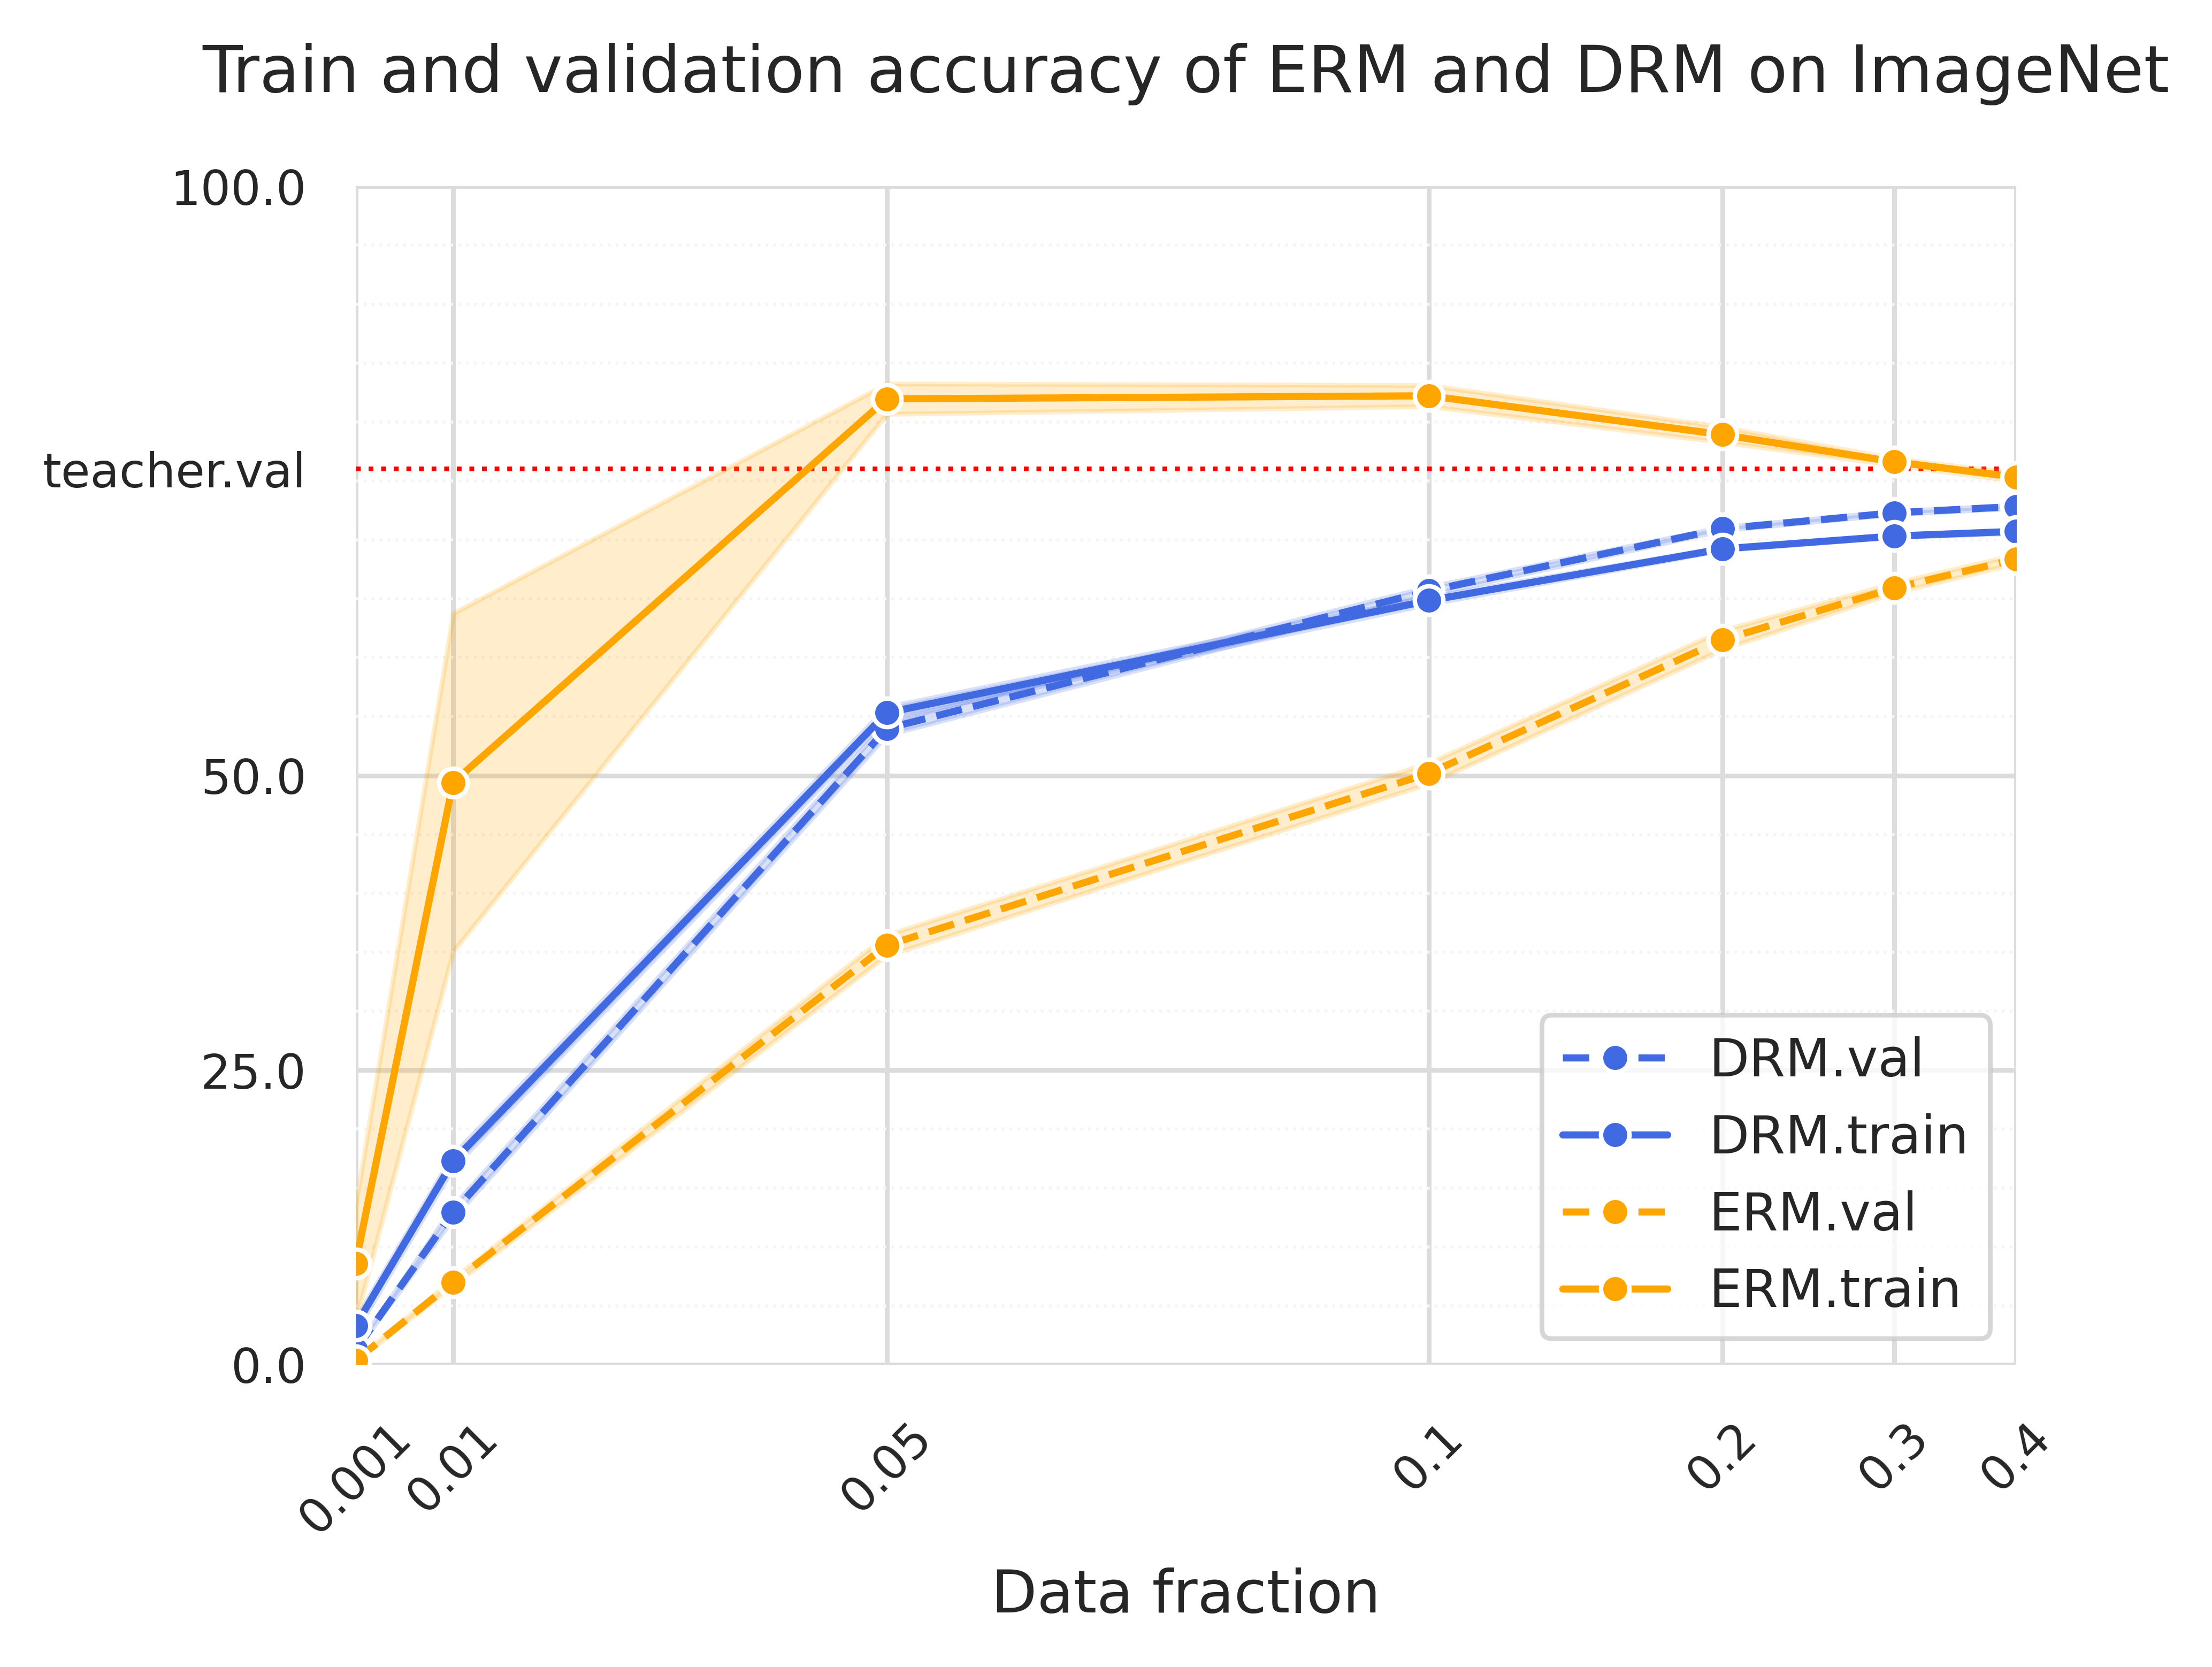

In [152]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']



    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(working_df['buffer_size_p'].unique())
    ax.set_xticklabels([ f'{l}' for l in working_df['buffer_size_p'].unique()], fontsize=8)
    ax.tick_params(axis='x',  rotation=45)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Train and validation accuracy of ERM and DRM on ImageNet", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Data fraction', fontsize=10, y=+5)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM.val','DRM.train',
                  'ERM.val','ERM.train',
                  'teacher.val','teacher.train'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('red')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


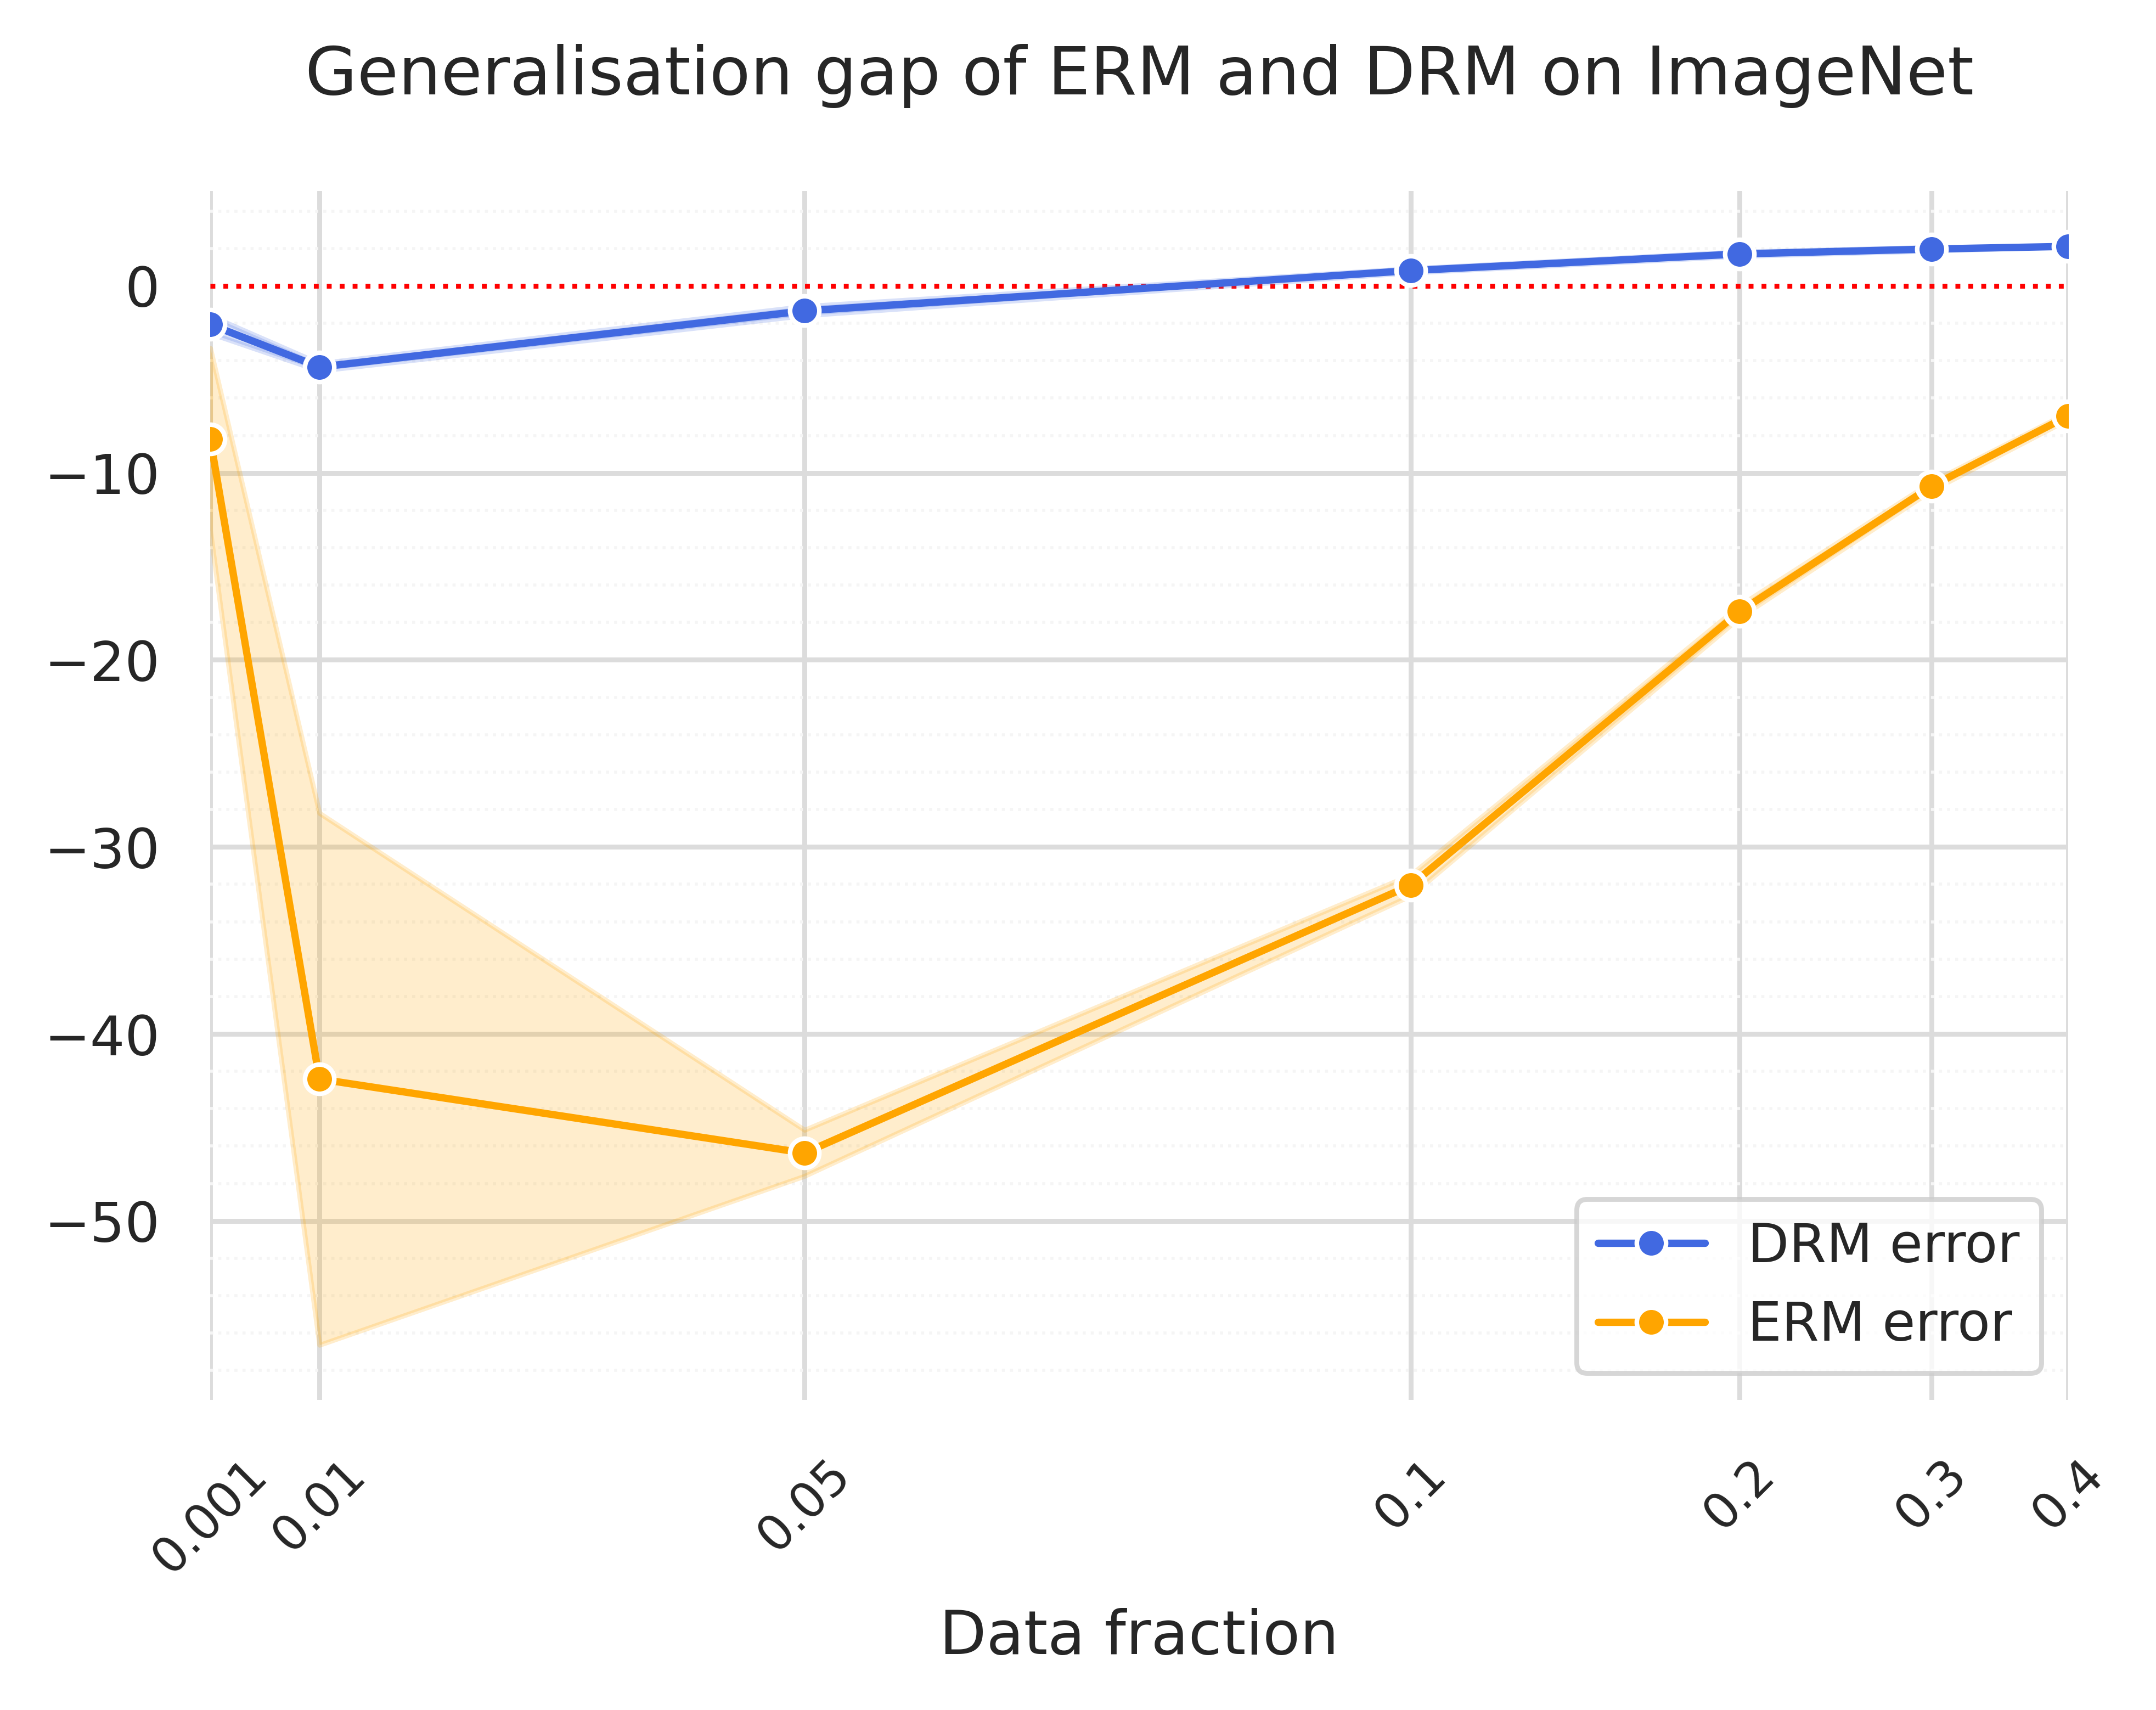

In [151]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']



    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="DRM error")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="ERM error")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    #ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(working_df['buffer_size_p'].unique())
    ax.set_xticklabels([ f'{l}' for l in working_df['buffer_size_p'].unique()], fontsize=8)
    ax.tick_params(axis='x',  rotation=45)

    #yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Generalisation gap of ERM and DRM on ImageNet", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Data fraction', fontsize=10, y=+5)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM error',
                  'ERM error'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[6]
    b.set_color('red')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


## Covariance exploration

In [5]:
from utils.loggers import *
from utils.conf import set_random_seed, get_device
from utils.status import ProgressBar

In [6]:
DEVICE=[1]
device = get_device(DEVICE)

In [7]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', distributed=False):
    path = base_path() + "/chkpts" + "/" + "imagenet" + "/" + "resnet50/"
    if best: filepath = path + 'model_best.pth.tar'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          if filename=='checkpoint_90.pth.tar' and not distributed: # modify Sidak's checkpoint
                new_state_dict = {k.replace('module.','',1):v for (k,v) in checkpoint['state_dict'].items()}
                checkpoint['state_dict'] = new_state_dict
          return checkpoint
    return None 

In [8]:
imagenet_root = "/local/home/stuff/imagenet/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_transform = transforms.Compose([
                            transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            normalize,
                        ])
inference_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])

train_dataset = ImageFolder(imagenet_root+'train', train_transform)
val_dataset = ImageFolder(imagenet_root+'val', inference_transform)

In [9]:
from torch.utils.data import ConcatDataset

In [10]:
all_data = ConcatDataset([train_dataset, val_dataset])
all_data_loader = DataLoader(
        all_data, batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)

In [11]:
# initialising the model
weights = None
model = resnet50(weights=weights)

chkpt_name = f"checkpoint_90.pth.tar" #sidak's checkpoint
checkpoint = load_checkpoint(best=False, filename=chkpt_name, distributed=False) #TODO: switch best off
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
best_acc1 = checkpoint['best_acc1']

Loading existing checkpoint ./logs//chkpts/imagenet/resnet50/checkpoint_90.pth.tar


#### First, we register train accuracy

In [12]:
train_loader = DataLoader(
        train_dataset, batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)
#TODO: add estimate of the average teacher logits magnitude
progress_bar = ProgressBar(verbose=True)
correct, total = 0.0, 0.0
average_magnitude = 0
for i,data in enumerate(train_loader):
        #if i==3: break
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            #average_magnitude += (outputs.max(dim=1)[0]-outputs.min(dim=1)[0]).sum(dim=0)
            average_non_max = (outputs.sum(dim=1) - outputs.max(dim=1)[0])/999 # average over the non-max outputs
            average_magnitude += (outputs.max(dim=1)[0] - average_non_max).sum(dim=0)
            _, pred = torch.max(outputs.data, 1)
            correct += torch.sum(pred == labels).item()
            total += labels.shape[0]
        progress_bar.prog(i, len(train_loader), (average_magnitude/total), 'D', (correct / total) * 100)     
acc=(correct / total) * 100
average_magnitude /= total

[ 08-10 | 12:18 ] Task D | epoch 14.51735782623291: |██████████████████████████████████████████████████| 2.87 ep/h | loss: 77.55202874 ||

In [ ]:
# max - min average = 19.93
# max - avg(rest) = 14.52

#### Now we collect all the labels and all the outputs

In [ ]:
# running estimate of the outer products and mean
Y2 = 0; Ymu = 0; t2 = 0; tmu = 0; total=0
C = 1000
progress_bar = ProgressBar(verbose=True)

for i, data in enumerate(all_data_loader):
    #if i==10: break # for testing
    with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = torch.nn.functional.one_hot(labels, num_classes=C).view(-1,C,1).to(torch.float64)
            outputs = model(inputs)
            outputs = torch.nn.functional.softmax(outputs.view(-1,C,1))
            total += labels.shape[0]
            Y2 += torch.matmul(labels,labels.permute(0,2,1)).sum(dim=0)
            Ymu += labels.sum(dim=0)
            t2 += torch.matmul(outputs,outputs.permute(0,2,1)).to(torch.float64).sum(dim=0)
            tmu += outputs.sum(dim=0)
    progress_bar.prog(i, len(all_data_loader), -1, 'D', i/(len(all_data_loader)))  
    
# summing over the batch dimension 
Ymu = Ymu/total
tmu = tmu/total
# subtracting the mean and averaging
SigmaY = (Y2 - torch.matmul(Ymu.view(C,1),Ymu.view(1,C)))/((total-1))
SigmaT = (t2 - torch.matmul(tmu.view(C,1),tmu.view(1,C)))/((total-1))

/tmp/ipykernel_2101918/2421696559.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs.view(-1,C,1))
[ 08-01 | 17:58 ] Task D | epoch -1: |██████████████████████████████████████████████████| 1.62 ep/h | loss: 0.99995192 |

In [ ]:
t2.shape

torch.Size([1000, 1000])

In [ ]:
SigmaY = SigmaY.detach().cpu().numpy()
SigmaT = SigmaT.detach().cpu().numpy()

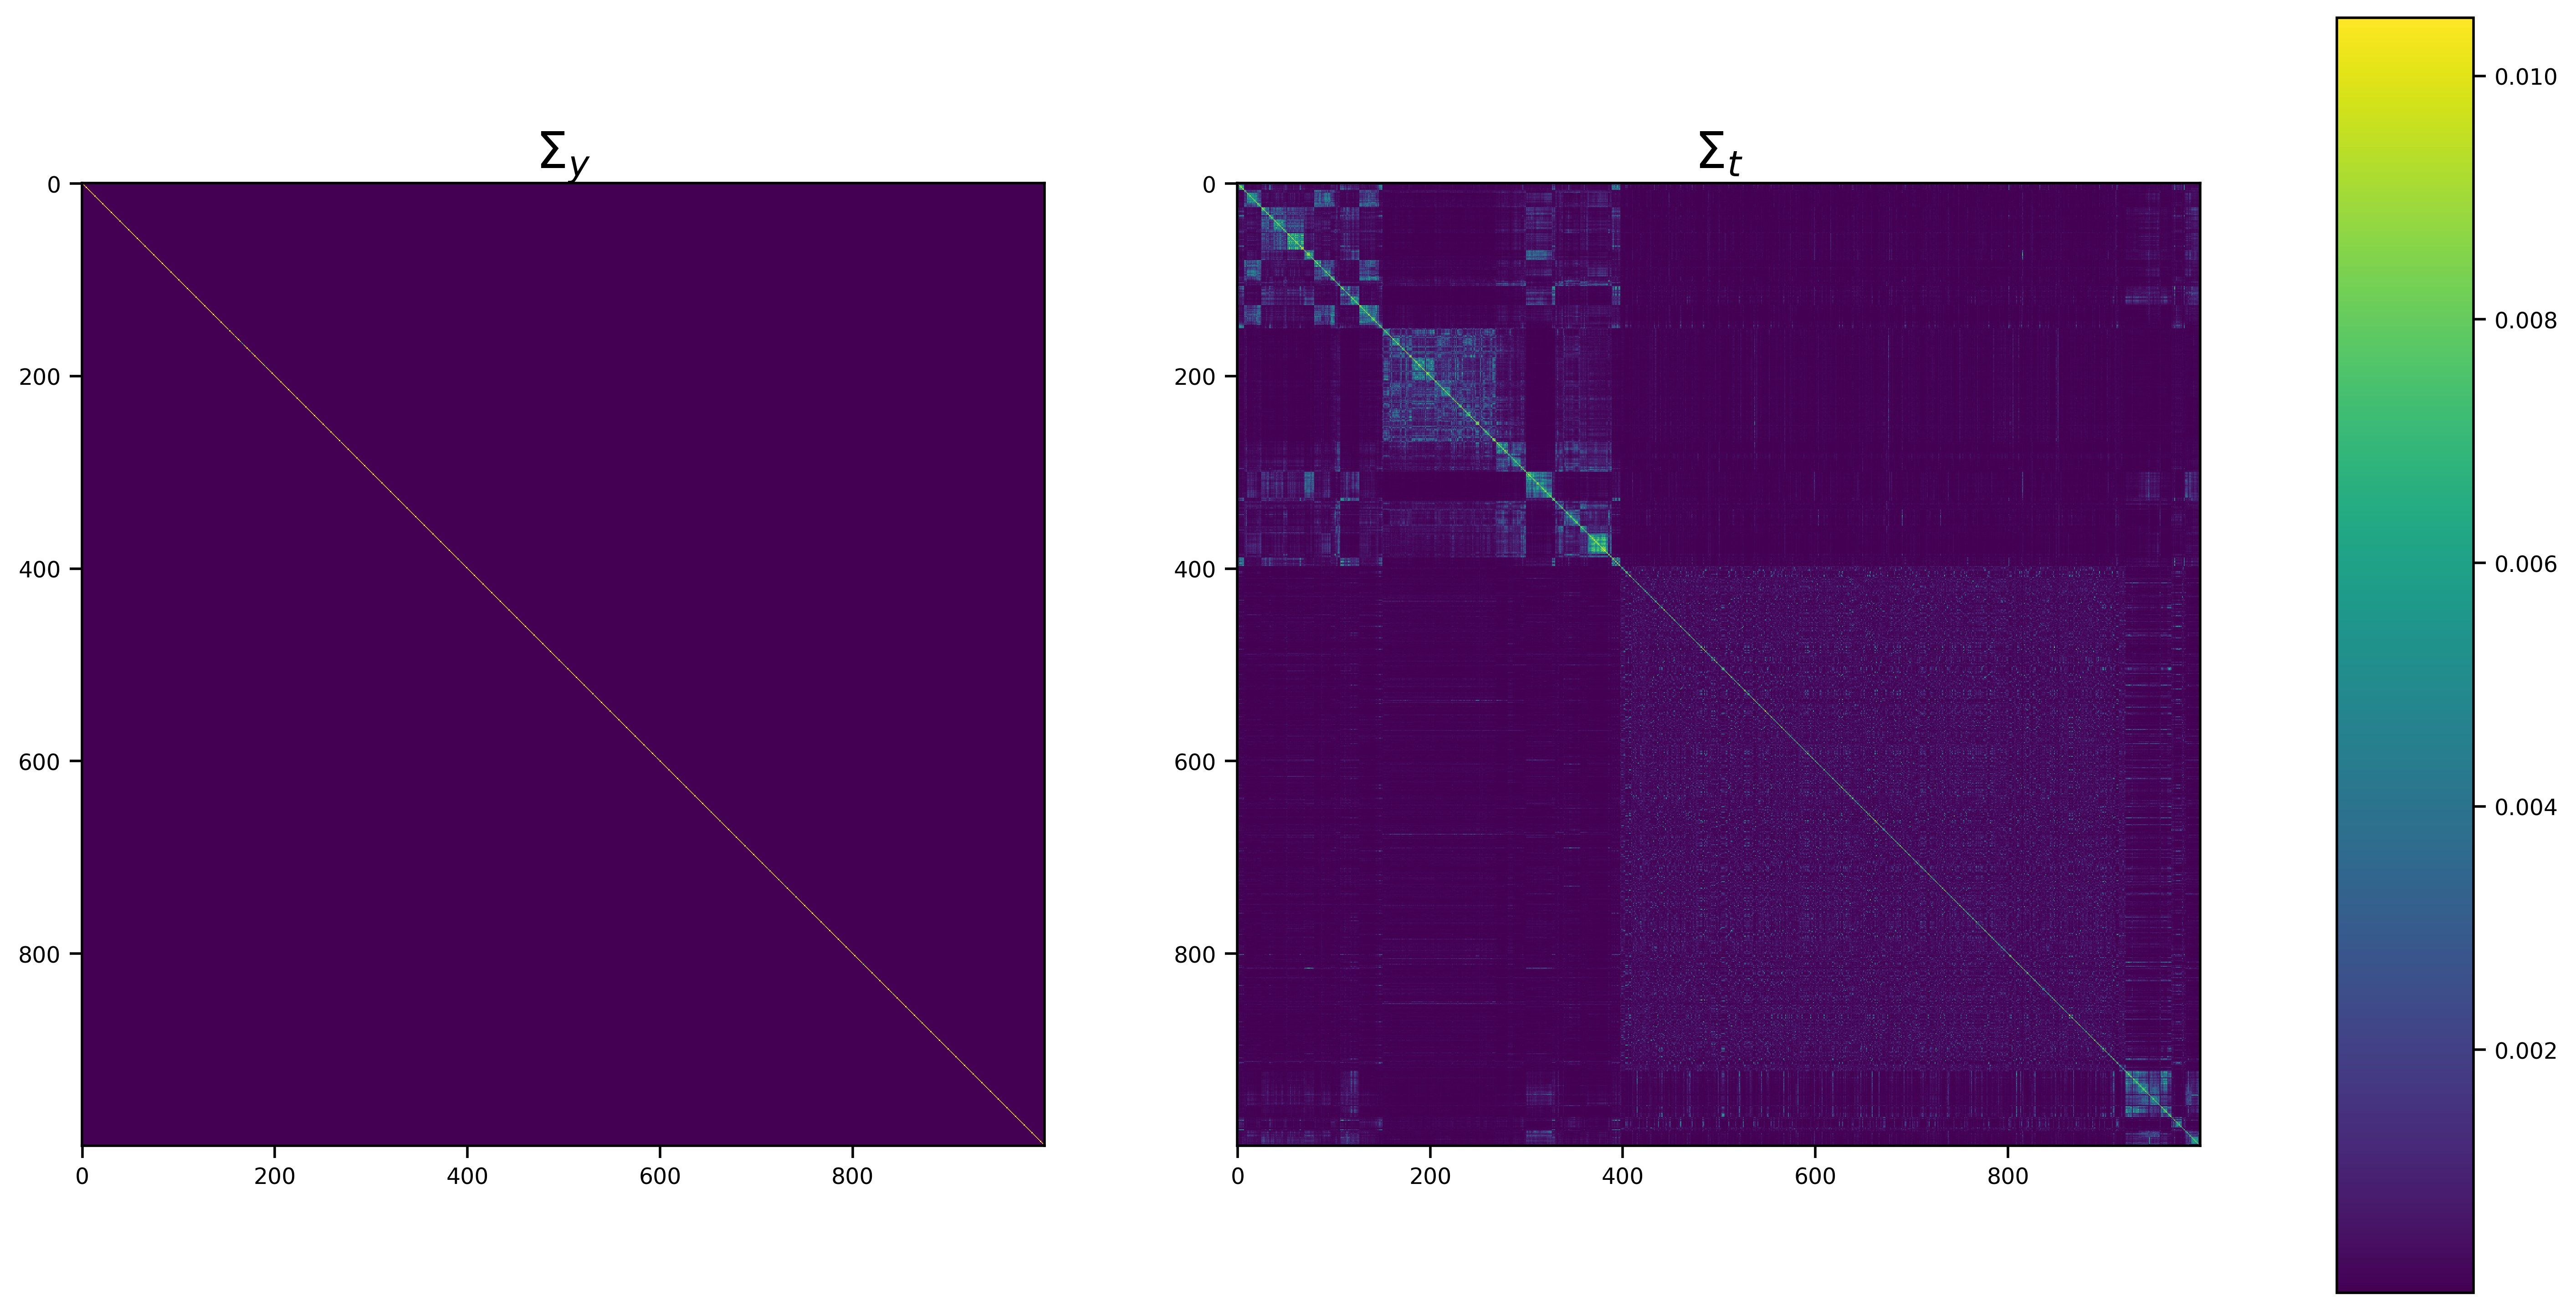

In [ ]:
#M = SigmaT.detach().cpu().numpy()
#assert (M == M.T).sum() == 1000**2
fig, ax = plt.subplots(1,2, figsize=(15,10), dpi=400)

mat = ax[0].matshow(SigmaY)
ax[0].set_title(r'$\Sigma_y$',fontsize=20)
ax[0].tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
ax[0].tick_params(axis='y', colors='black', bottom=True, top=False)

mat = ax[1].matshow(SigmaT)
ax[1].set_title(r'$\Sigma_t$',fontsize=20)
ax[1].tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
ax[1].tick_params(axis='y', colors='black', bottom=True, top=False)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(mat, cax=cbar_ax, fraction=0.046, pad=0.04)
#fig.colorbar(mat, ax=ax[1], location='right', anchor=(0, 0.5), shrink=0.7)

In [57]:
path=base_path() + "/results" + "/imagenet" + "/resnet50" + "/"
np.save(path + "SigmaY.npy", SigmaY)
np.save(path + "SigmaT.npy", SigmaT)

In [22]:
path=base_path() + "/results" + "/imagenet" + "/resnet50" + "/"
with open(path+ "SigmaY.npy", 'rb') as f:
    SigmaY = np.load(f)
with open(path+ "SigmaT.npy", 'rb') as f:
    SigmaT = np.load(f)

Now we perform an eigenvalue analysis

Text(0.5, 1.0, 'Distribution')

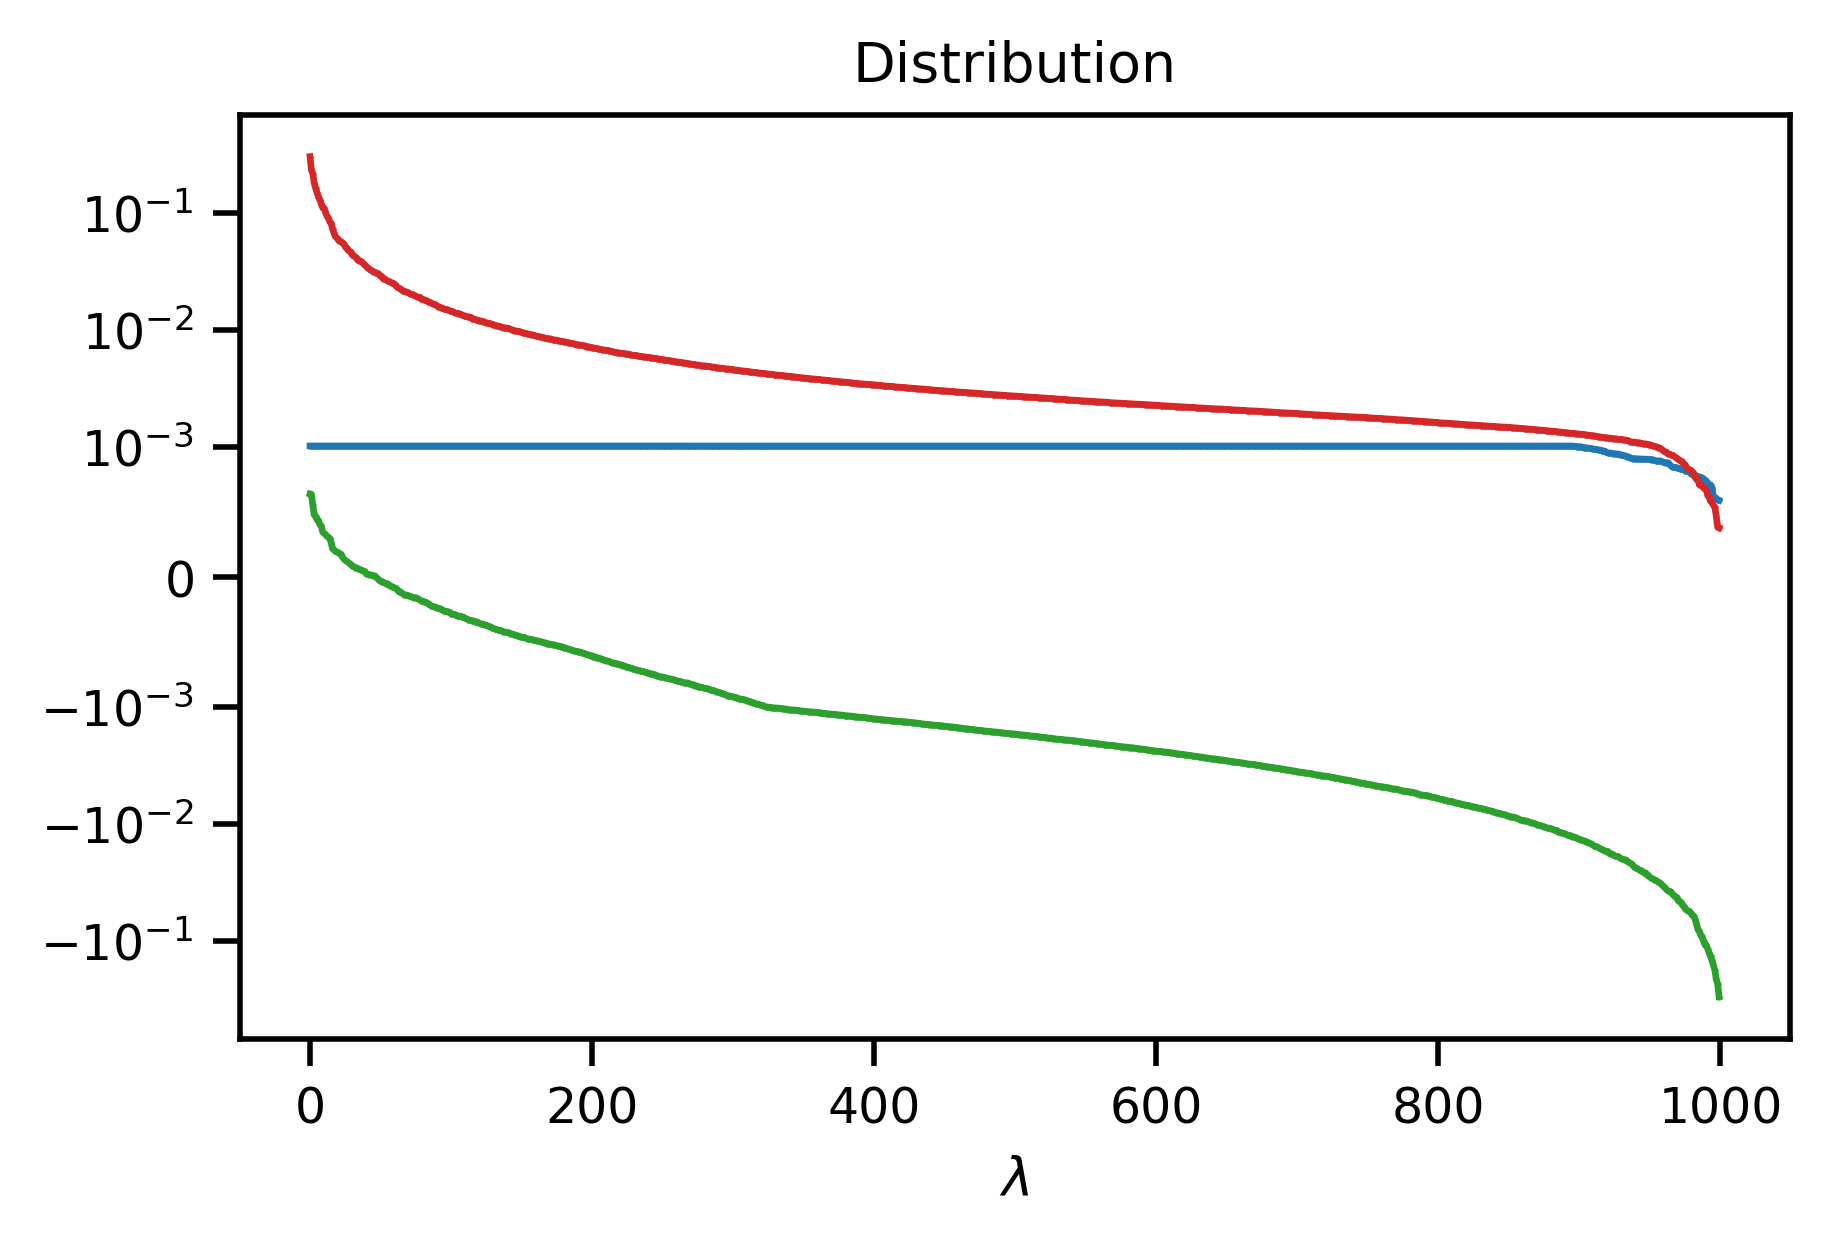

In [23]:
fig, ax = plt.subplots(figsize=(5,3), dpi=400)

L, V = np.linalg.eigh(SigmaY)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:red')
x = list(range(L.shape[0]))
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:blue', ms=0.5)
L, V = np.linalg.eigh(SigmaT)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:blue')
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:red', ms=0.5)
L, V = np.linalg.eigh(SigmaY-SigmaT)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:blue')
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:green', ms=0.5)
#ax.set_xscale('symlog', linthresh=0.001)
ax.set_yscale('symlog', linthresh=10e-4)
#ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$')
ax.set_title('Distribution', fontsize=10)


In [25]:
L, V = np.linalg.eigh(SigmaY-SigmaT)

In [26]:
L.sum()

-6.910937427854297